<a href="https://colab.research.google.com/github/seeedata/BADA/blob/main/%ED%96%89%EC%82%AC%20%EC%B0%B8%EC%97%AC%20%EC%9D%B8%EC%9B%90%20%EC%98%88%EC%B8%A1%EC%9D%84%20%ED%86%B5%ED%95%9C%20%EC%95%88%EC%A0%84%20%EA%B4%80%EB%A6%AC%20%EC%BB%A8%EC%84%A4%ED%8C%85%20%EC%84%9C%EB%B9%84%EC%8A%A4/0922%20net%20%EC%A7%80%EC%88%98%20%EC%9E%AC%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DAB/Model /기상청/최종시간별날씨데이터(결측치대체).csv', encoding='utf-8-sig'); df

,측정일자,측정요일명,주말여부,측정시,시간내적설량,기온,풍속,습도,시간내강수량,눈,비
0,2012-01-01,7,1,0,0.0,0.4,1.5,69.0,0.0,0,0
1,2012-01-01,7,1,1,0.0,0.3,2.3,72.0,0.0,0,0
2,2012-01-01,7,1,2,0.0,-0.1,1.3,73.0,0.0,0,0
3,2012-01-01,7,1,3,0.0,-0.5,0.8,74.0,0.0,0,0
4,2012-01-01,7,1,4,0.0,-1.2,1.5,77.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
98587,2023-03-31,5,0,19,0.0,18.0,3.1,37.0,0.0,0,0
98588,2023-03-31,5,0,20,0.0,16.2,3.0,36.0,0.0,0,0
98589,2023-03-31,5,0,21,0.0,14.8,2.4,40.0,0.0,0,0
98590,2023-03-31,5,0,22,0.0,14.0,1.8,41.0,0.0,0,0


[]

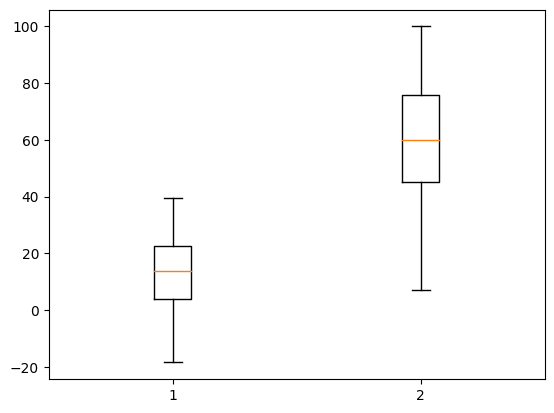

In [ ]:
fig, ax = plt.subplots()
ax.boxplot([df['기온'],df['습도']])
ax.plot()

[]

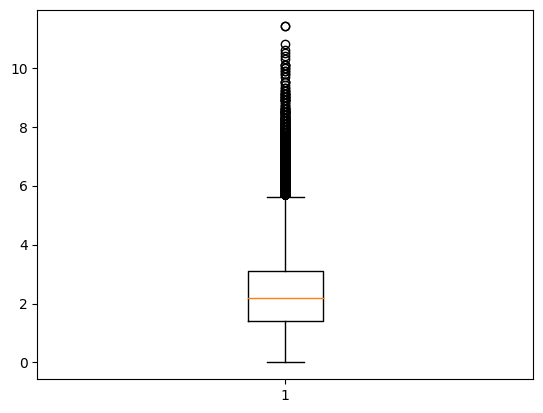

In [ ]:
fig, ax = plt.subplots()
ax.boxplot([df['풍속']])
ax.plot()

In [ ]:
df = df.iloc[:, [0, 3, 5, 6, 7]]; df.head(1)

,측정일자,측정시,기온,풍속,습도
0,2012-01-01,0,0.4,1.5,69.0


In [ ]:
df.describe()

,측정시,기온,풍속,습도
count,98592.000000,98592.000000,98592.000000,98592.000000
mean,11.500000,13.005161,2.363868,60.346984
std,6.922222,11.152556,1.309264,19.809212
min,0.000000,-18.500000,0.000000,7.000000
25%,5.750000,3.800000,1.400000,45.000000
50%,11.500000,13.900000,2.200000,60.000000
75%,17.250000,22.600000,3.100000,76.000000
max,23.000000,39.400000,11.400000,100.000000


In [ ]:
df.columns = ['date', 'time', 'temp', 'wind', 'hum']

In [ ]:
df.isna().sum()

date    0
time    0
temp    0
wind    0
hum     0
dtype: int64

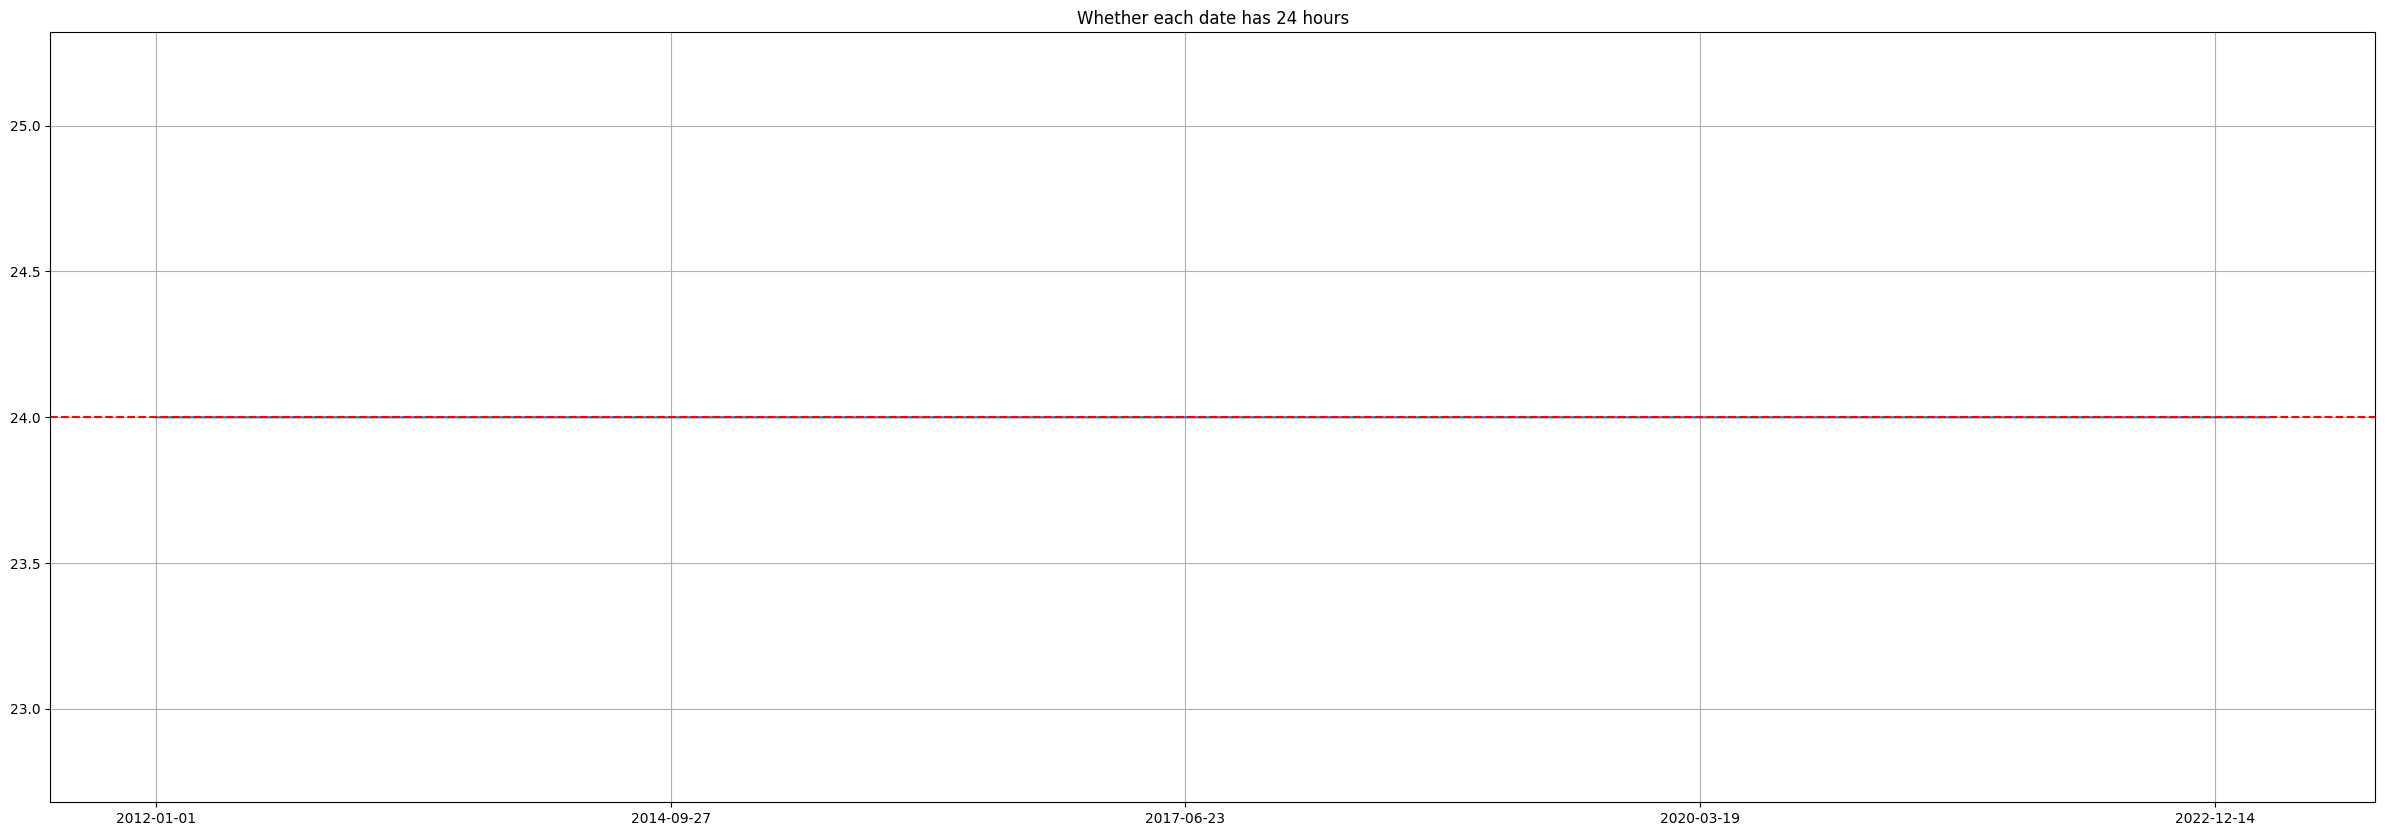

In [ ]:
#일별로 24개의 관측치가 있는지 확인해보자
plt.figure(figsize=(30,10))
ax = df['date'].value_counts().sort_index().plot()
plt.axhline(y=24, color='r', linestyle='--')
plt.title('Whether each date has 24 hours')
plt.grid()
plt.show()

#### NET 지수 생성

In [ ]:
#NET 계산 함수를 만들자

def NET(df):
    T = df['temp']
    V = df['wind']
    RH = df['hum']
    df.loc[:, 'net'] = 37 - ((37-T) / (0.68 - 0.0014*RH + 1/(1.76+1.4*(V**0.75)))) - 0.29*T*(1-0.01*RH)
    return df

In [ ]:
NET(df)

,date,time,temp,wind,hum,net
0,2012-01-01,0,0.4,1.5,69.0,-5.752748
1,2012-01-01,1,0.3,2.3,72.0,-8.457159
2,2012-01-01,2,-0.1,1.3,73.0,-5.810780
3,2012-01-01,3,-0.5,0.8,74.0,-3.899180
4,2012-01-01,4,-1.2,1.5,77.0,-8.094663
...,...,...,...,...,...,...
98587,2023-03-31,19,18.0,3.1,37.0,10.736152
98588,2023-03-31,20,16.2,3.0,36.0,8.980255
98589,2023-03-31,21,14.8,2.4,40.0,8.252944
98590,2023-03-31,22,14.0,1.8,41.0,8.369550


In [ ]:
df.net.describe()

count    98592.000000
mean         7.030827
std         12.057990
min        -31.601866
25%         -2.741358
50%          7.962673
75%         17.542088
max         32.868707
Name: net, dtype: float64

NET 기준 이상치 탐지

##### max 기준 이상치

In [ ]:
# Find the index of the rows with maximum 'net' value for each date
idx = df.groupby('date')['net'].idxmax()

# Create a new DataFrame with the selected rows
net_max_df = df.loc[idx, ['date', 'net', 'time', 'temp', 'hum', 'wind']]

print(net_max_df)

             date        net  time  temp   hum  wind
3      2012-01-01  -3.899180     3  -0.5  74.0   0.8
38     2012-01-02  -5.924142    14  -1.2  48.0   1.5
53     2012-01-03  -4.494919     5  -6.3  76.0   0.2
88     2012-01-04 -13.032028    16  -4.6  39.0   3.3
117    2012-01-05  -3.285244    21  -4.6  50.0   0.4
...           ...        ...   ...   ...   ...   ...
98487  2023-03-27   7.557482    15  14.2  24.0   2.5
98498  2023-03-28   8.244327     2   4.5  75.0   0.0
98534  2023-03-29  12.767479    14  19.6  31.0   2.5
98560  2023-03-30  13.721810    16  21.0  26.0   2.8
98582  2023-03-31  16.239248    14  23.2  25.0   2.2

[4108 rows x 6 columns]


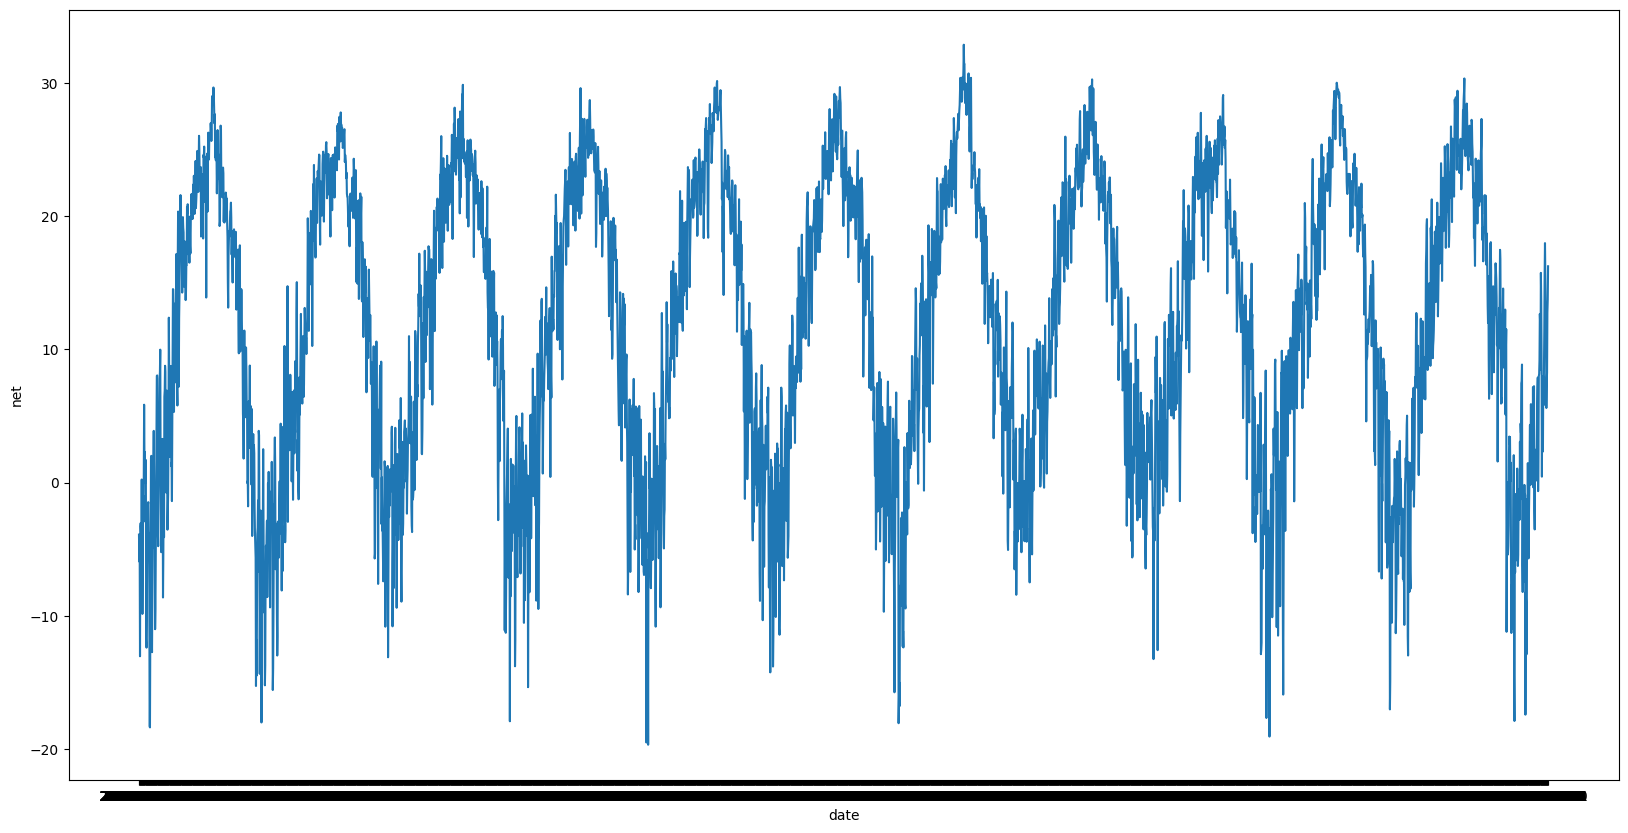

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(x='date', y='net', data=net_max_df)
plt.show()

In [ ]:
net_max_df_sort = net_max_df.sort_values(by='net', ascending=False); net_max_df_sort

,date,net,time,temp,hum,wind
57712,2018-08-01,32.868707,16,39.4,39.0,2.5
57759,2018-08-03,31.417574,15,37.4,44.0,3.2
57737,2018-08-02,31.398503,17,37.4,44.0,2.3
57689,2018-07-31,31.036233,17,38.0,36.0,1.3
58047,2018-08-15,30.716226,15,37.4,38.0,1.4
...,...,...,...,...,...,...
767,2012-02-01,-18.278591,23,-15.0,51.0,1.2
791,2012-02-02,-18.370092,23,-12.7,54.0,1.6
79097,2021-01-08,-19.061017,17,-11.7,39.0,2.7
35518,2016-01-19,-19.507612,22,-13.0,54.0,1.8


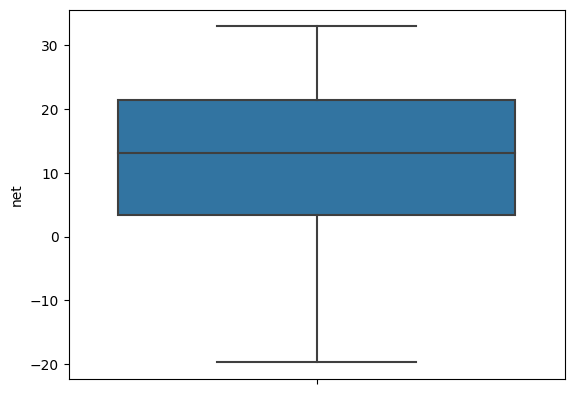

In [ ]:
sns.boxplot(data=net_max_df_sort, y='net')
plt.show()

In [ ]:
#상위 5% 데이터
df1 = net_max_df_sort[net_max_df_sort.reset_index(drop=True).index <= (3729*0.05)]; df1

,date,net,time,temp,hum,wind
57712,2018-08-01,32.868707,16,39.4,39.0,2.5
57759,2018-08-03,31.417574,15,37.4,44.0,3.2
57737,2018-08-02,31.398503,17,37.4,44.0,2.3
57689,2018-07-31,31.036233,17,38.0,36.0,1.3
58047,2018-08-15,30.716226,15,37.4,38.0,1.4
...,...,...,...,...,...,...
92176,2022-07-07,26.833217,16,30.9,74.0,3.0
40024,2016-07-25,26.813873,16,31.3,63.0,2.0
14150,2013-08-12,26.809740,14,32.2,57.0,3.9
39662,2016-07-10,26.796756,14,32.6,47.0,2.2


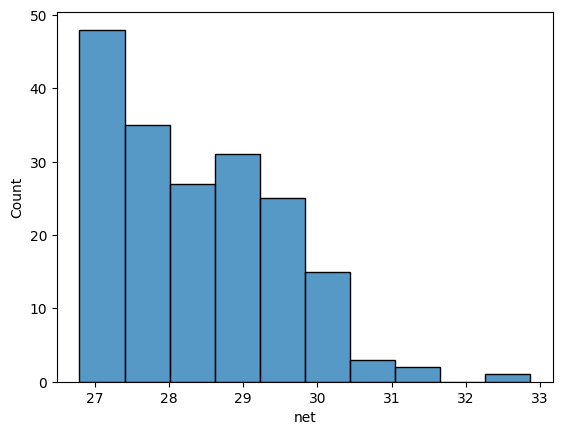

In [ ]:
sns.histplot(data=df1, x='net')
plt.show()

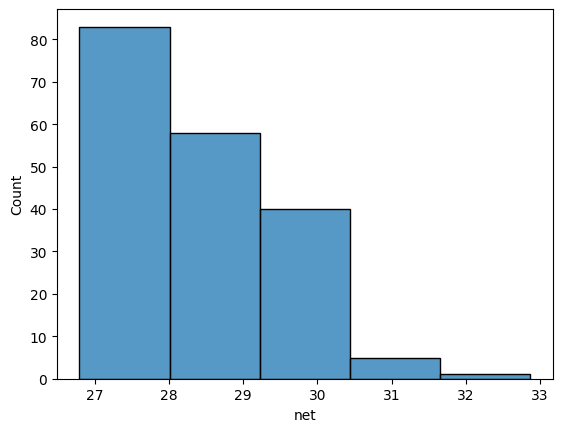

In [ ]:
sns.histplot(data=df1, x='net', bins=5)
plt.show()

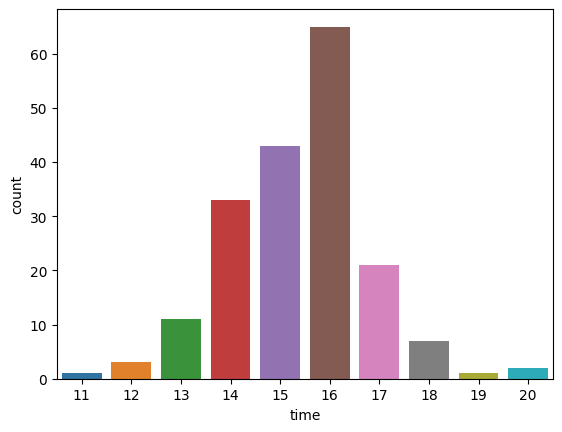

In [ ]:
sns.countplot(data=df1, x='time')
plt.show()

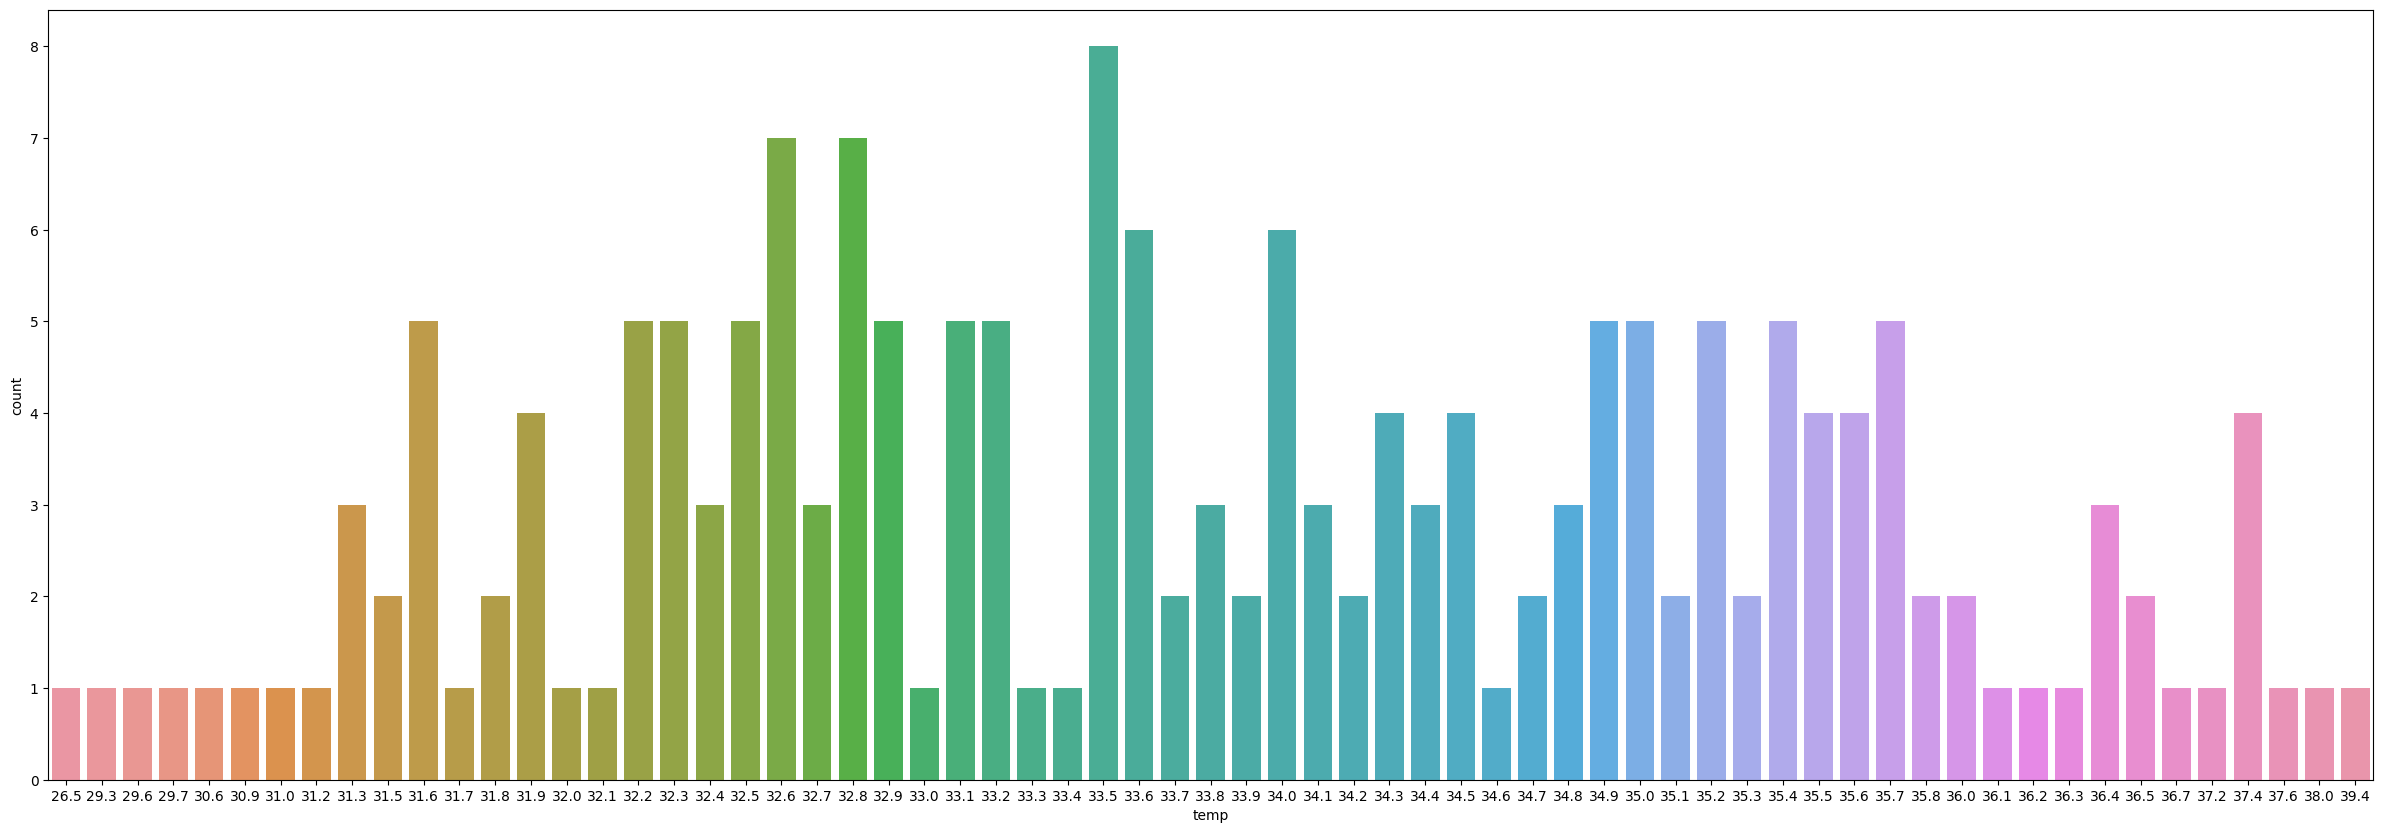

In [ ]:
plt.figure(figsize=(30,10))
sns.countplot(data=df1, x='temp')
plt.show()

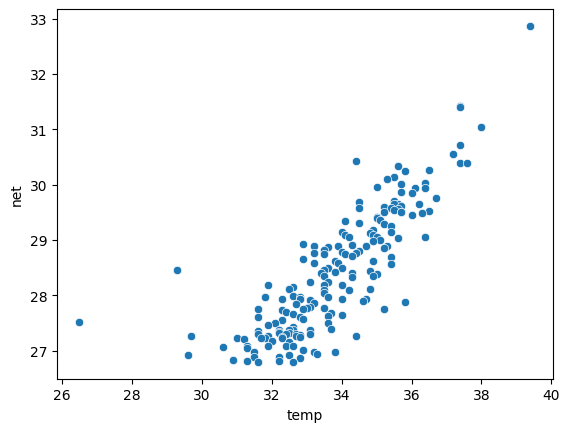

In [ ]:
#기온이 높을수록 net도 높아질까?
sns.scatterplot(x='temp', y='net', data=df1)
plt.show()

##### min 기준 이상치

In [ ]:
# Find the index of the rows with minimum 'net' value for each date
idx = df.groupby('date')['net'].idxmin()

# Create a new DataFrame with the selected rows
net_min_df = df.loc[idx, ['date', 'net', 'time', 'temp', 'hum', 'wind']]

print(net_min_df)

             date        net  time  temp   hum  wind
19     2012-01-01 -18.193881    19  -5.3  58.0   4.8
33     2012-01-02 -19.950161     9  -7.3  75.0   3.2
56     2012-01-03 -18.748381     8  -6.6  80.0   2.8
77     2012-01-04 -22.658764     5  -8.6  65.0   4.5
103    2012-01-05 -15.802340     7  -9.6  71.0   1.3
...           ...        ...   ...   ...   ...   ...
98477  2023-03-27  -3.975529     5   3.3  45.0   2.6
98503  2023-03-28  -5.630666     7   2.8  73.0   2.3
98525  2023-03-29  -2.020309     5   5.4  75.0   2.0
98550  2023-03-30   0.591865     6   6.6  57.0   1.8
98575  2023-03-31   0.464164     7   7.6  60.0   2.3

[4108 rows x 6 columns]


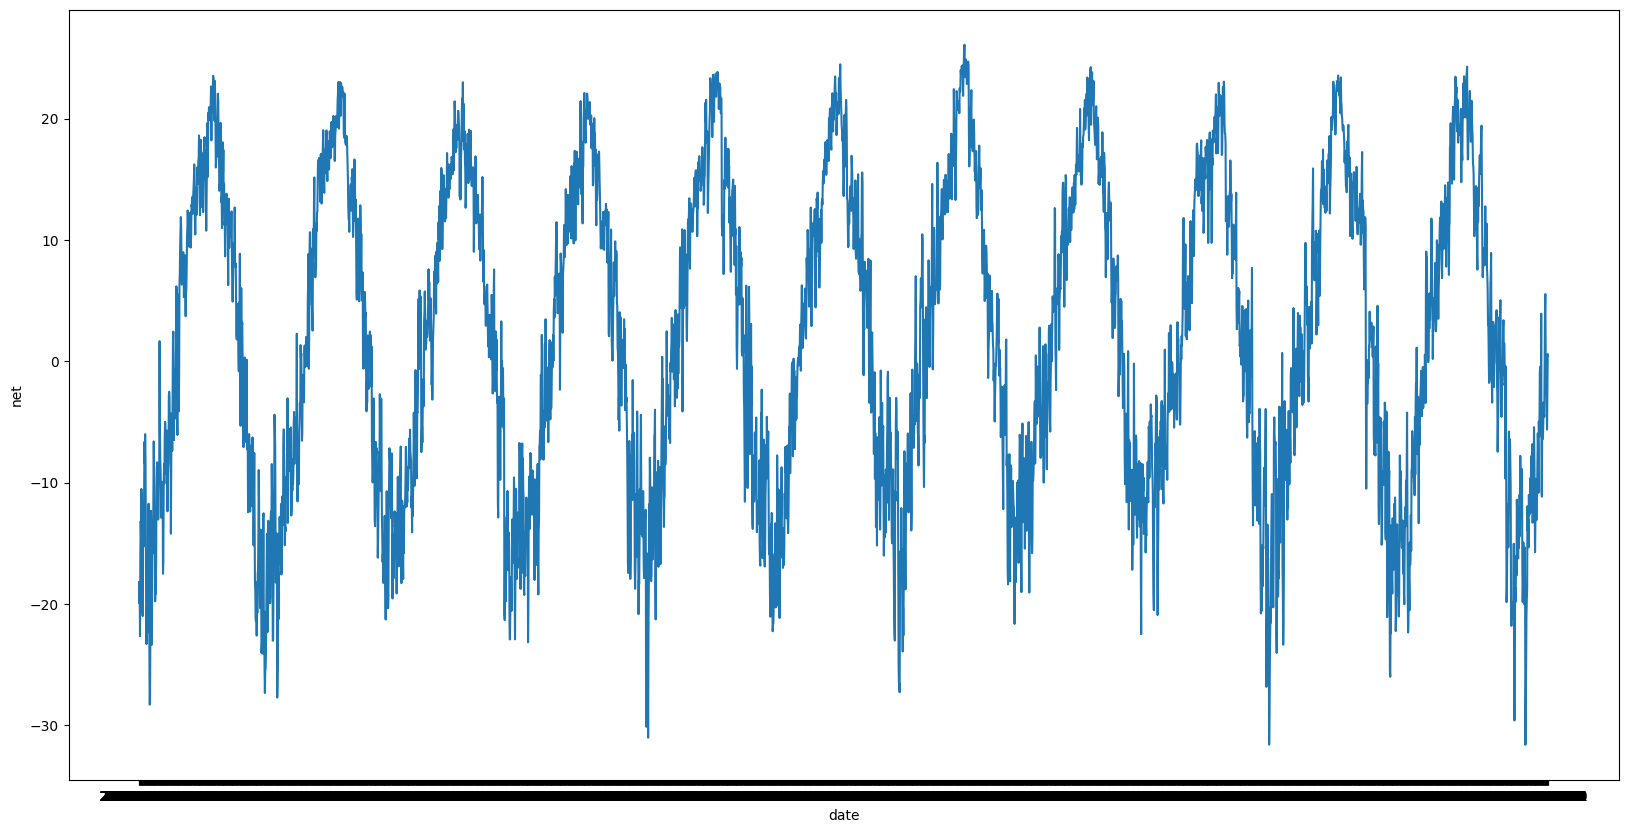

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(x='date', y='net', data=net_min_df)
plt.show()

In [ ]:
net_min_df_sort = net_min_df.sort_values(by='net', ascending=True); net_min_df_sort

,date,net,time,temp,hum,wind
96991,2023-01-24,-31.601866,7,-15.6,55.0,5.9
79062,2021-01-07,-31.598190,6,-15.6,58.0,5.5
35624,2016-01-24,-31.019944,8,-18.0,58.0,3.6
35503,2016-01-19,-30.127017,7,-14.7,50.0,6.3
96220,2022-12-23,-29.602701,4,-13.2,62.0,5.7
...,...,...,...,...,...,...
58010,2018-08-14,24.691902,2,28.6,70.0,1.5
57870,2018-08-08,24.783585,6,27.6,84.0,1.2
57816,2018-08-06,24.910210,0,28.7,79.0,2.2
57726,2018-08-02,25.554201,6,30.4,54.0,1.3


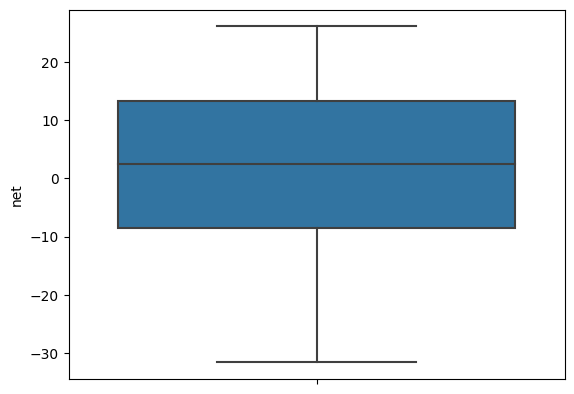

In [ ]:
sns.boxplot(data=net_min_df_sort, y='net')
plt.show()

In [ ]:
#하위 5% 데이터
df2 = net_min_df_sort[net_min_df_sort.reset_index(drop=True).index <= (3729*0.05)]; df2

,date,net,time,temp,hum,wind
96991,2023-01-24,-31.601866,7,-15.6,55.0,5.9
79062,2021-01-07,-31.598190,6,-15.6,58.0,5.5
35624,2016-01-24,-31.019944,8,-18.0,58.0,3.6
35503,2016-01-19,-30.127017,7,-14.7,50.0,6.3
96220,2022-12-23,-29.602701,4,-13.2,62.0,5.7
...,...,...,...,...,...,...
96982,2023-01-23,-18.539947,22,-5.0,70.0,4.3
78608,2020-12-19,-18.539538,8,-9.5,53.0,2.7
79617,2021-01-30,-18.510515,9,-5.6,72.0,3.7
26334,2015-01-02,-18.448462,6,-8.3,59.0,2.9


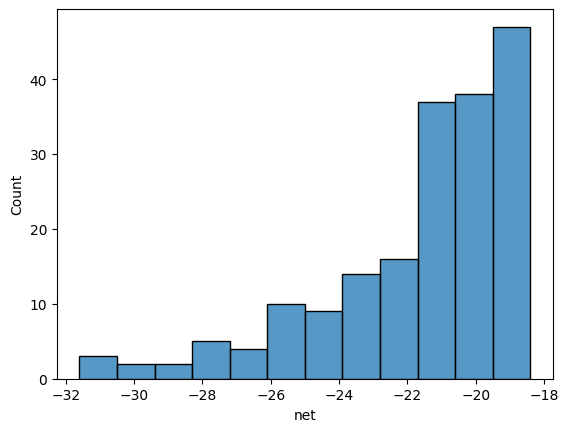

In [ ]:
sns.histplot(data=df2, x='net')
plt.show()

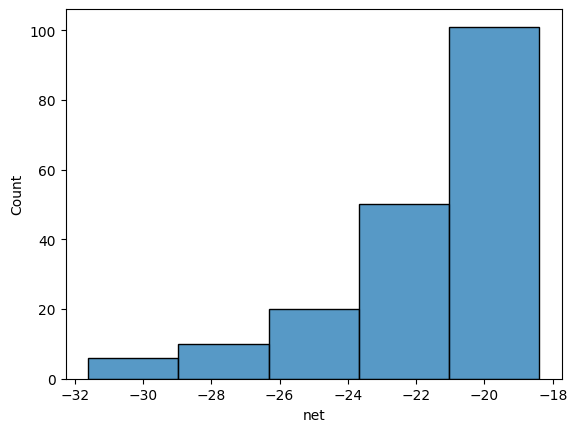

In [ ]:
sns.histplot(data=df2, x='net', bins=5)
plt.show()

[]

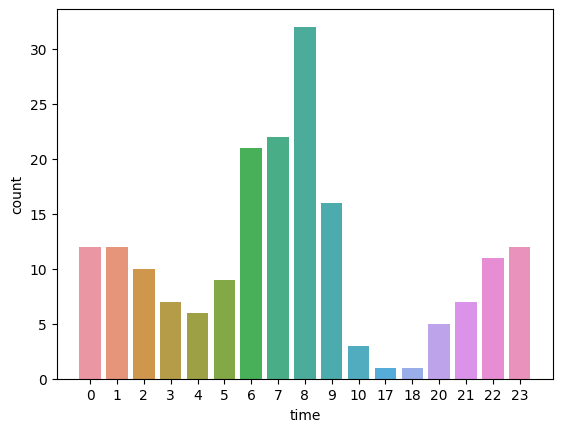

In [ ]:
sns.countplot(data=df2, x='time')
plt.plot()

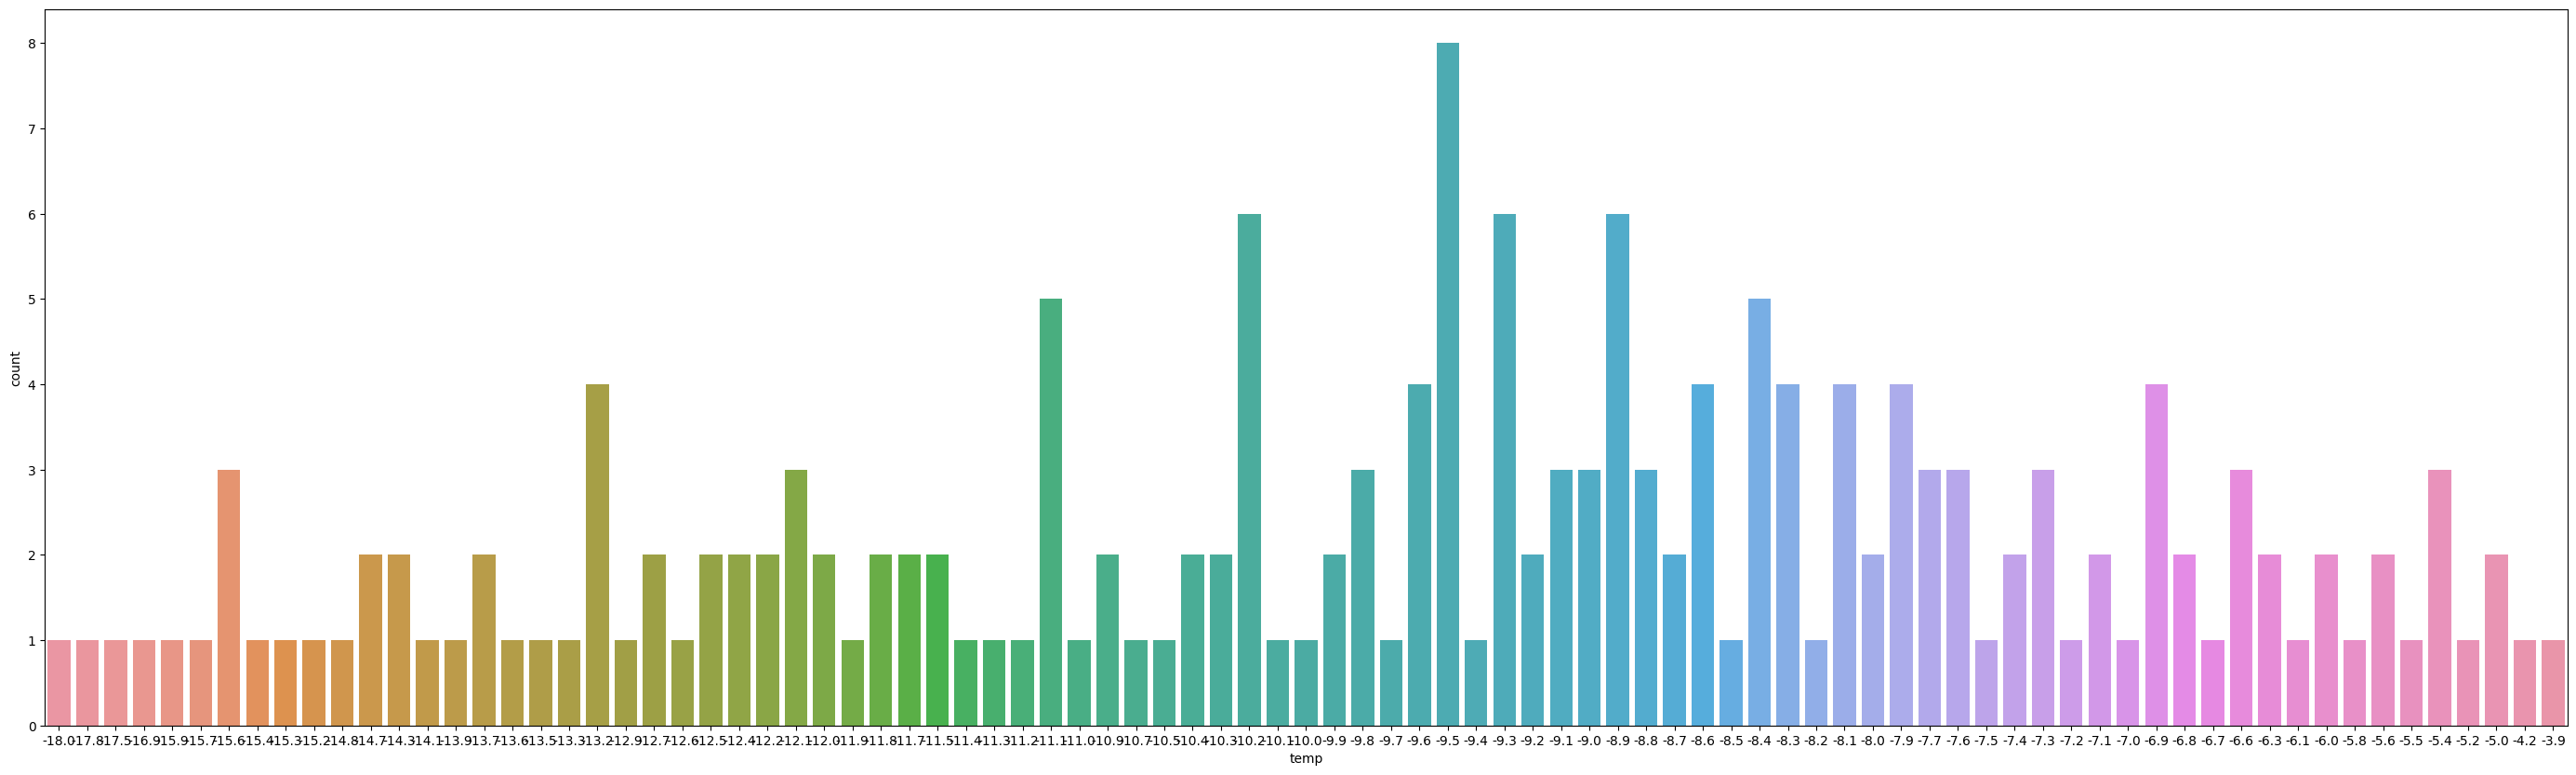

In [ ]:
plt.figure(figsize=(35,10))
sns.countplot(data=df2, x='temp')
plt.show()

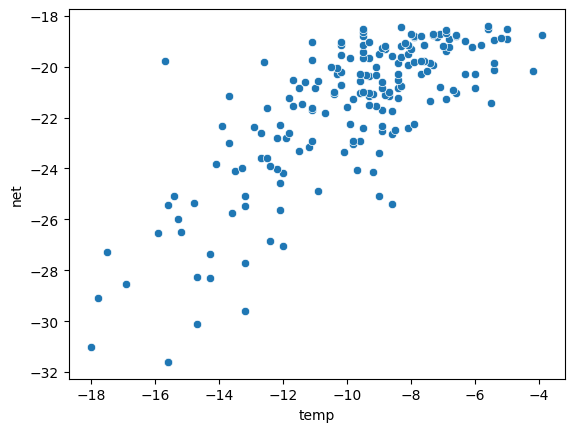

In [ ]:
#기온이 낮을수록 net도 낮아질까?
sns.scatterplot(x='temp', y='net', data=df2)
plt.show()ㅍ

In [ ]:
df_origin = pd.read_csv('/content/drive/MyDrive/DAB/Model /기상청/최종시간별날씨데이터(결측치대체).csv', encoding='utf-8-sig')

,date,time,temp,wind,hum,net
0,2012-01-01,0,0.4,1.5,69.0,-5.752748
1,2012-01-01,1,0.3,2.3,72.0,-8.457159
2,2012-01-01,2,-0.1,1.3,73.0,-5.810780
3,2012-01-01,3,-0.5,0.8,74.0,-3.899180
4,2012-01-01,4,-1.2,1.5,77.0,-8.094663
...,...,...,...,...,...,...
98587,2023-03-31,19,18.0,3.1,37.0,10.736152
98588,2023-03-31,20,16.2,3.0,36.0,8.980255
98589,2023-03-31,21,14.8,2.4,40.0,8.252944
98590,2023-03-31,22,14.0,1.8,41.0,8.369550


In [ ]:
df_origin['NET'] = df['net']